In [62]:
from src.DBtools import copy_from_db, connect_to_db, run_query

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import botometer

botometer_keys = json.load(open("data/botometer_api_keys.json","r"))
bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=botometer_keys.pop("rapidapi_key"),
                          **botometer_keys)

In [2]:
su_df = pd.read_csv("data/suspended_users.csv")
su_df["suspension_date"] = pd.to_datetime(su_df["suspension_date"])
databases = json.load(open("data/databases.json","r"))

In [77]:
base_query = """SELECT * FROM {} WHERE retweeted_status_user_id = {} AND created_at>'{}' AND created_at<'{}'"""

for db_name in databases["dbs"]:
    connection = connect_to_db(host=databases["host"], user=databases["username"], db=db_name)
    for row in su_df.itertuples():
        print(f"Collecting retweet data for {row.user_screen_name} from {db_name} database...")
        suspension_date = row.suspension_date
        start_date = suspension_date - pd.Timedelta("32 d")
        end_date = suspension_date + pd.Timedelta("32 d")
        outfile = "data/database_retweets/{}_retweets_{}.csv".format(row.user_screen_name,db_name)

        query = base_query.format(databases["tweet_table"],
                                row.user_id,
                                str(start_date),
                                str(end_date))
        copy_from_db(query,connection,outfile)

SELECT * FROM public.tweet WHERE retweeted_status_user_id = 87679233 AND created_at>'2021-07-27 23:30:20+00:00' AND created_at<'2021-09-29 23:30:20+00:00'
SELECT * FROM public.tweet WHERE retweeted_status_user_id = 289420613 AND created_at>'2021-05-04 02:24:55+00:00' AND created_at<'2021-07-07 02:24:55+00:00'
SELECT * FROM public.tweet WHERE retweeted_status_user_id = 3302113075 AND created_at>'2021-04-11 02:55:48+00:00' AND created_at<'2021-06-14 02:55:48+00:00'
SELECT * FROM public.tweet WHERE retweeted_status_user_id = 35013035 AND created_at>'2021-05-29 16:02:36+00:00' AND created_at<'2021-08-01 16:02:36+00:00'
SELECT * FROM public.tweet WHERE retweeted_status_user_id = 21632108 AND created_at>'2021-08-13 17:17:12+00:00' AND created_at<'2021-10-16 17:17:12+00:00'
SELECT * FROM public.tweet WHERE retweeted_status_user_id = 39844876 AND created_at>'2021-11-27 17:08:56+00:00' AND created_at<'2022-01-30 17:08:56+00:00'
SELECT * FROM public.tweet WHERE retweeted_status_user_id = 8767923

In [3]:
#Read in retweet data from databases
df_list = []
for row in su_df.itertuples():    
    #establish related suspension date
    suspension_date = row.suspension_date
    start_window = suspension_date - pd.Timedelta(30, "d")

    #load in the data from the databases
    retweet_dfs = []
    for db_name in databases["dbs"]:
        retweet_dfs.append(pd.read_csv(f"data/database_retweets/{row.user_screen_name}_retweets_{db_name}.csv",dtype={"id":str,
                                                                                                         "retweeted_status_id":str,
                                                                                                         "quoted_status_id":str,
                                                                                                         "in_reply_to_status_id":str}))
    #drop the duplicate tweets between databases
    retweet_df = pd.concat(retweet_dfs).drop_duplicates("id") 
    
    #take only the data from the 30 day window before the user suspension
    retweet_df["created_at"] = pd.to_datetime(retweet_df["created_at"],errors="coerce")
    retweet_df = retweet_df[(retweet_df.created_at>=start_window ) & (retweet_df.created_at <= suspension_date)]

    
    #add to the list
    retweet_df["suspended_user"]=row.user_screen_name
    df_list.append(retweet_df) 
    
all_retweets = pd.concat(df_list) 

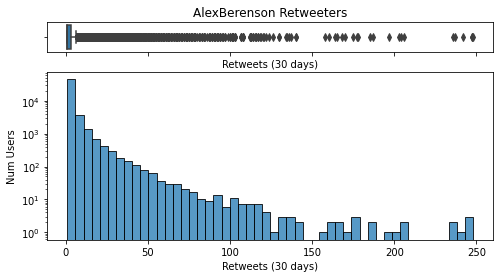

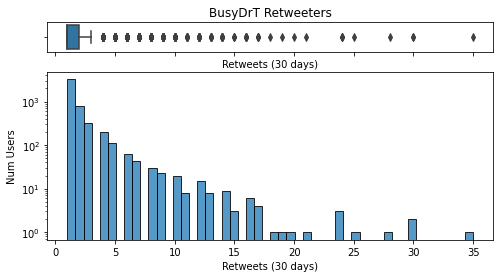

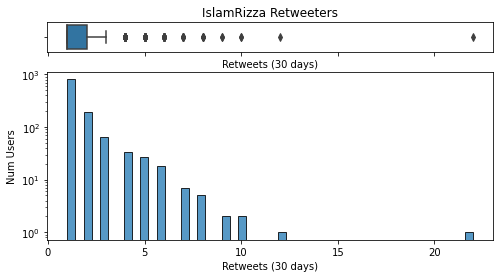

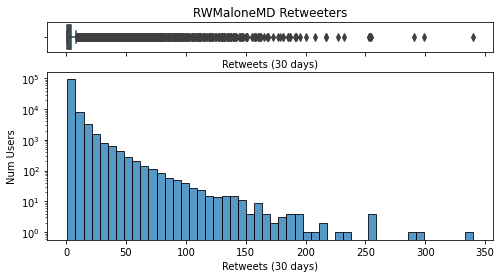

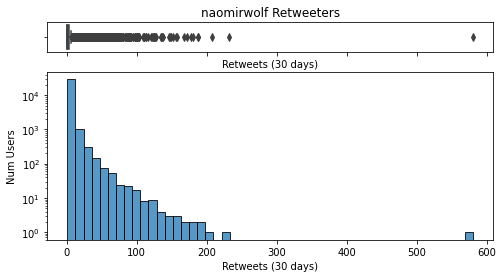

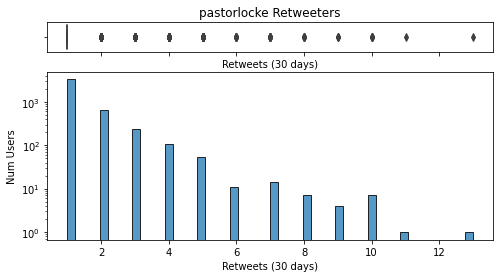

In [4]:
for su, sub_df in all_retweets.groupby("suspended_user"): 
    rt_counts = pd.DataFrame(sub_df.user_id.value_counts())

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(8,4))
    sns.boxplot(x=rt_counts["user_id"], whis=1.5,ax=ax_box)
    bin_count=50
    sns.histplot(data=rt_counts, x="user_id", ax=ax_hist,log_scale=(False, True),bins=bin_count)

    # Remove x axis name for the boxplot
    ax_hist.set(xlabel='Retweets (30 days)',ylabel="Num Users")
    ax_box.set(xlabel='Retweets (30 days)')
    ax_box.set(title=f"{su} Retweeters")
    plt.show()

In [11]:
#Take the top 100 frequent retweeters for each user
top_rt_dict = {}
for row in su_df.itertuples():
    su = row.user_screen_name
    top_retweeters = all_retweets[(all_retweets.retweeted_status_user_screen_name==su) & (all_retweets.user_screen_name !=su)].user_id.value_counts()[:100].index
    top_rt_dict.update({su:top_retweeters})
    
#save the top retweeters for each suspended user as a dataframe and as a text file 
top_rt_df = pd.DataFrame(top_rt_dict).melt().rename({"variable":"suspended_user","value":"retweeter_user_id"},axis=1)

#get botomoter scores for each user in this group 
botometer_results = []
for user_id, result in tqdm(bom.check_accounts_in(top_rt_df.retweeter_user_id)):
    botometer_results.append(result)

top_rt_df["botometer_output"]=botometer_results
top_rt_df.to_csv("data/top_retweeters_pool.csv",index=False)


In [27]:
#Take a sample from a group of users who are still highly engaged, but more moderately so. 
#This is defined by first creating a group who retweeted the suspended user more than once in the 30 days preceding suspension
#Then sampling from the group of users that fall between the median and 75th percentile in terms of how frequently they retweeted the suspended user

moderate_retweeter_dict = {}
for row in su_df.itertuples():
    su = row.user_screen_name
    #get retweet counts for all users
    rt_counts = all_retweets[(all_retweets.retweeted_status_user_screen_name==su) & (all_retweets.user_screen_name !=su)].user_id.value_counts()
    #drop users with <2 retweets
    rt_counts = rt_counts[rt_counts>1]
    
    median_rts = np.quantile(rt_counts,0.5)
    perc_75_rts = np.quantile(rt_counts,0.75)
    
    sample_pool = rt_counts[(rt_counts >=median_rts) & (rt_counts<=perc_75_rts)]
    user_sample = sample_pool.sample(n=75,random_state=42)
    moderate_retweeter_dict.update({su:user_sample.index})
    

moderate_rt_df = pd.DataFrame(moderate_retweeter_dict).melt().rename({"variable":"suspended_user","value":"retweeter_user_id"},axis=1)

#Get the botometer score for each 
botometer_results = []

for user_id, result in tqdm(bom.check_accounts_in(moderate_rt_df.retweeter_user_id)):
    botometer_results.append(result)
    
moderate_rt_df["botometer_output"]=botometer_results
moderate_rt_df.to_csv("data/moderate_retweeters_pool.csv")


In [76]:
#From the pools that have been established in the previous step, narrow down to only those who are still reachable through Twitter's API 
#That is, accounts that are not suspended, deleted, or private.
top_rt_df["inaccesible"] = top_rt_df.botometer_output.apply(lambda x:x.get("error") is not None)

#take only the top 50 TW api accessible retweeters
top_rt_df["su_retweets"] = top_rt_df.apply(lambda row: all_retweets[(all_retweets.suspended_user==row.suspended_user) & (all_retweets.user_id==row.retweeter_user_id)].id.nunique(), axis=1)
top_rt_df = top_rt_df[~top_rt_df.inaccesible]
top_rt_df = top_rt_df.loc[top_rt_df.sample(frac=1,random_state=42).groupby("suspended_user")["su_retweets"].nlargest(50,keep="first").reset_index(level="suspended_user").index]

#save final user list
top_rt_df.to_csv("data/top_retweeters.csv")
                 
moderate_rt_df["inaccesible"] = moderate_rt_df.botometer_output.apply(lambda x:x.get("error") is not None)

#drop users that are already in the top group
moderate_rt_df = moderate_rt_df[~moderate_rt_df.retweeter_user_id.isin(top_rt_df.retweeter_user_id)]
moderate_rt_df["su_retweets"] = moderate_rt_df.apply(lambda row: all_retweets[(all_retweets.suspended_user==row.suspended_user) & (all_retweets.user_id==row.retweeter_user_id)].id.nunique(), axis=1)

#get 50 random from the median group that are accessible
moderate_rt_df = moderate_rt_df[~moderate_rt_df.inaccesible].groupby("suspended_user").sample(n=50,random_state=42)

#save final user list
moderate_rt_df.to_csv("data/moderate_retweeters.csv")
